In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [27]:
( train_ds , test_ds ) , ds_info = tfds.load('mnist', split = ['train', 'test'], as_supervised = True , with_info = True )


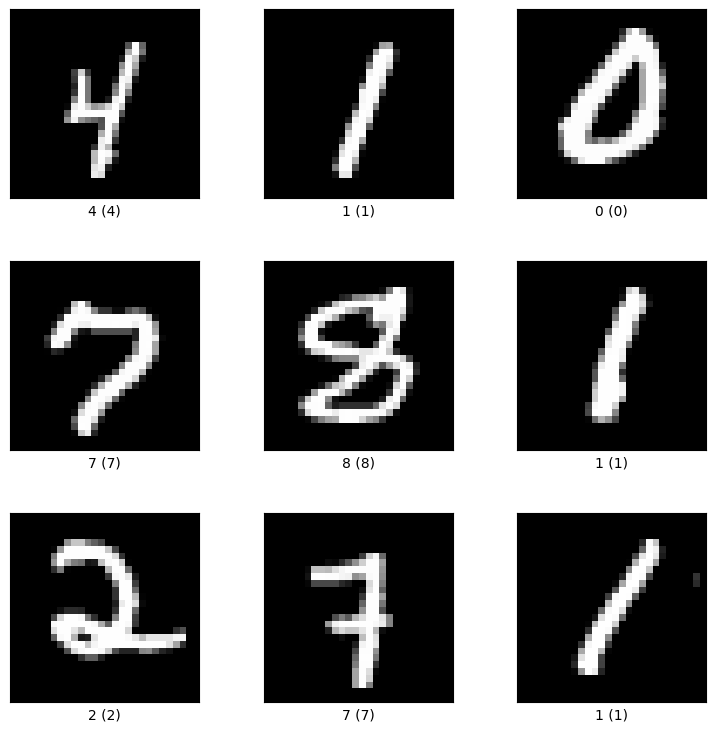

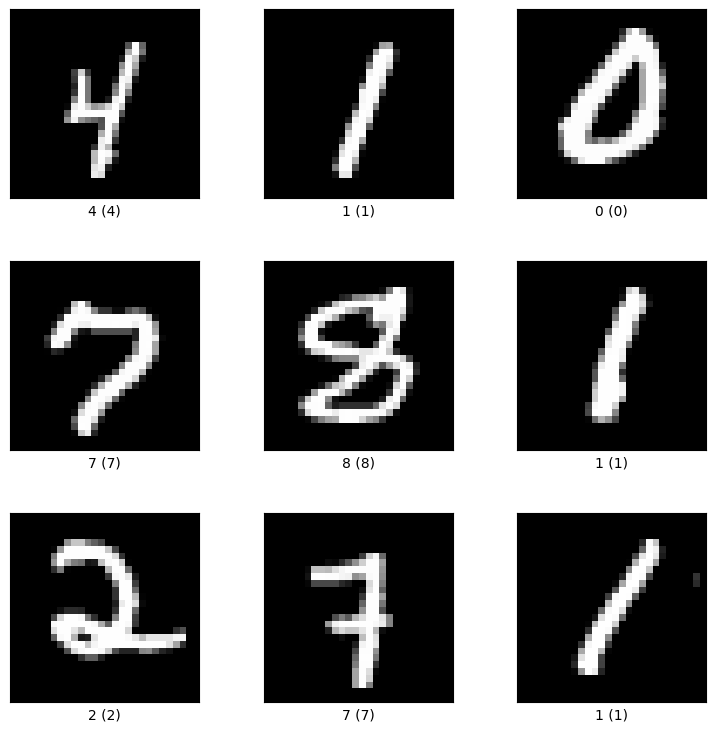

In [28]:
tfds.show_examples(train_ds,ds_info)

In [29]:
def preprocess(mnist):
  # convert to float
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32),target))
  # flatten the image
  mnist = mnist.map(lambda img, target: (tf.reshape(img,(-1,)),target))
  # normalize img
  mnist = mnist.map(lambda img, target: ((img/128.) - 1., target))
  # one-hot encode targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  # cache the progress
  mnist = mnist.cache()

  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(25)
  mnist = mnist.prefetch(18)

  return mnist


In [30]:
train_dataset = train_ds.apply(preprocess)
test_dataset = test_ds.apply(preprocess)


In [40]:
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        first_layer_output = self.dense1(inputs)
        second_layer_output = self.dense2(first_layer_output)
        final_output = self.out(second_layer_output)
        return final_output


In [41]:
def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [43]:
tf.keras.backend.clear_session()

train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 5
learning_rate = 0.01

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.KLDivergence()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    _, train_accuracy = test(model, train_dataset, cross_entropy_loss)
    train_accuracies.append(train_accuracy)

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.0784
Epoch: 1 starting with accuracy 0.9039999999999999
Epoch: 2 starting with accuracy 0.9203999999999999
Epoch: 3 starting with accuracy 0.9316
Epoch: 4 starting with accuracy 0.9428


In [34]:
import matplotlib.pyplot as plt

def visualization ( train_losses ,  test_losses, train_accuracies ,test_accuracies ):
  """ Visualizes accuracy and loss for training and test data using
  the mean of each epoch .
  Loss is displayed in a regular line , accuracy in a dotted
  line .
  Training data is displayed in blue , test data in red .
  Parameters
  ----------
  train_losses : numpy . ndarray
  training losses
  train_accuracies : numpy . ndarray
  training accuracies
  test_losses : numpy . ndarray
  test losses
  test_accuracies : numpy . ndarray
  test accuracies
  """
  plt.figure ()
  line1 , = plt . plot ( train_losses , "b-")
  line2 , = plt . plot ( test_losses , "r-")
  line3 , = plt . plot ( train_accuracies , "b:")
  line4 , = plt . plot ( test_accuracies , "r:")
  plt . xlabel (" Training steps ")
  plt . ylabel (" Loss / Accuracy ")
  plt . legend (( line1 , line2 , line3 , line4 ) , (" training loss ", " testloss ", " train accuracy ", " test accuracy "))
  plt . show ()


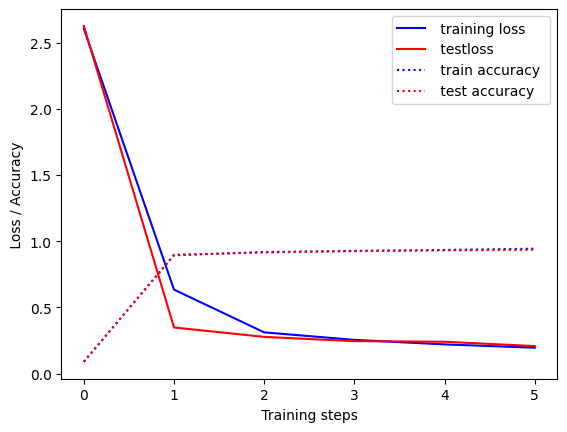

In [39]:
visualization(train_losses, test_losses, train_accuracies, test_accuracies )

## Case 1: standard hw setup
optimizer, loss_function, learning_rate, number_of_nodes, layers, epochs = SGD, CCE, 0.1, 256, 2, 5

**95% final accuracy**. Great start!

CCE Loss works well with multiclass targets. Along with a high learning rate, we see that the loss decreases significantly after the first epoch itself. The accuracy starts fluctuating as the number of epochs increases due to greater chances of overfitting.<br>
By the 5th epoch, the changes are minimal, hence kept that as the standard number of epochs for all the cases

## Case 2: lowering the learning rate

optimizer, loss_function, learning_rate, number_of_nodes, layers, epochs = SGD, CCE, 0.00001, 256, 2, 5

**13% final accuracy**. Complete failure

No learning happens. The name is self explanatory, but to understand it mathematically. Learning rate determines to what scale do the parameters get adjusted. Given the scaling factor is negligible, there appears to be extremely small adjustments, and hence no learning.


## Case 3: reducing the number of nodes while keeping a better learning rate

optimizer, loss_function, learning_rate, number_of_nodes, layers, epochs = SGD, CCE, 0.001, 64, 2, 5

**86% final accuracy**. Slowly bouncing back

As expected, the training time significantly reduces. The better learning rate keeps it away from the disastrous results like the last one. Its not bad, but not the best either.

## Case 4: Optimal case?

optimizer, loss_function, learning_rate, number_of_nodes, layers, epochs = SGD, CCE, 0.01, 128, 2, 5

**93% final accuracy**. Quite good

Misses the best accuracy by 2%, while decreasing the computations by half; a good trade-off in my opinion. The optimal case with SGD and CCE as the optimizer and loss function respectively can be arguably around these numbers.

## Case 5: KLDivergence

optimizer, loss_function, learning_rate, number_of_nodes, layers, epochs = SGD, KLDivergence, 0.01, 100, 2, 5

**93% final accuracy**. Nice!

KLDivergence being another loss function widely used for multiclass classifications shows similar results.
